In [1]:
using Clustering
using LinearAlgebra
using Plots
using Random
using SparseArrays
using Gurobi
using JuMP
Random.seed!(1234);  # determinism

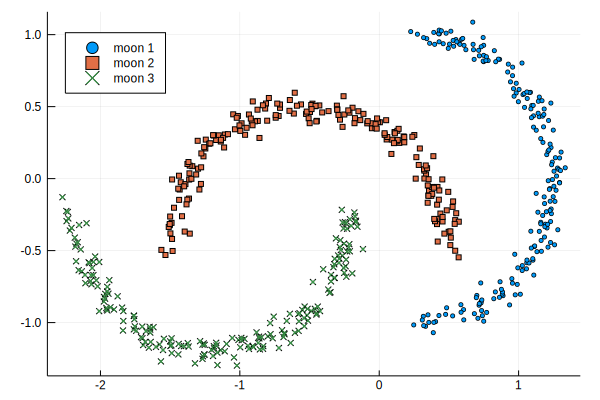

In [2]:
# Three moons
N = 200;
t = sort(rand(N) * π)
moon1 = [sin.(t) .+ 0.25 cos.(t)] .+ 0.05 * randn(N,2)
moon2 = [cos.(t) sin.(t)] .+ 0.05 * randn(N,2) .- 0.5
moon3 = [cos.(t) .- 1.2 -sin.(t) .- 0.2] .+ 0.05 * randn(N,2)
moons = [moon1; moon2; moon3]
scatter( moon1[:,1], moon1[:,2], marker=:circle, markersize=2, label="moon 1", legend=:topleft)
scatter!(moon2[:,1], moon2[:,2], marker=:square, markersize=2, label="moon 2")
scatter!(moon3[:,1], moon3[:,2], marker=:X,      markersize=2, label="moon 3")

┌ Warning: implicit `dims=2` argument now has to be passed explicitly to specify that distances between columns should be computed
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: implicit `dims=2` argument now has to be passed explicitly to specify that distances between columns should be computed
│   caller = _kmeans!(::Adjoint{Float64,Array{Float64,2}}, ::Nothing, ::Array{Float64,2}, ::Array{Int64,1}, ::Array{Float64,1}, ::Array{Int64,1}, ::Array{Float64,1}, ::Int64, ::Float64, ::Int64, ::Distances.SqEuclidean) at kmeans.jl:115
└ @ Clustering /Users/arb/.julia/packages/Clustering/pvAp6/src/kmeans.jl:115


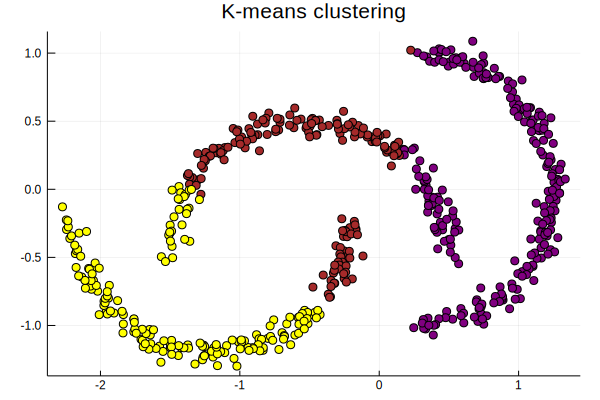

In [3]:
# k means clustering of three moons
assignments = kmeans(moons', 3).assignments
inds1, inds2, inds3 = [findall(assignments .== i) for i = 1:3]
scatter( moons[inds1,1], moons[inds1,2], color="purple", label="")
scatter!(moons[inds2,1], moons[inds2,2], color="brown",  label="")
scatter!(moons[inds3,1], moons[inds3,2], color="yellow", label="")
title!("K-means clustering")

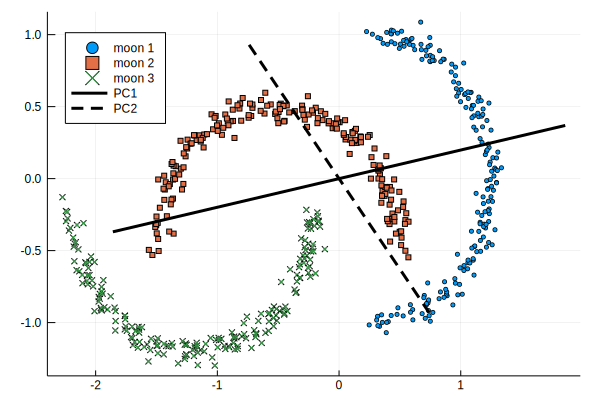

In [4]:
# PCA of three mooons
F = svd(moons)
V = F.V
dir1x, dir1y = 2 * [-V[1,1], V[1,1]], [-V[2,1], V[2,1]]
dir2x, dir2y = 2 * [-V[1,2], V[1,2]], [-V[2,2], V[2,2]]
scatter( moon1[:,1], moon1[:,2], marker=:circle, markersize=2, label="moon 1", legend=:topleft)
scatter!(moon2[:,1], moon2[:,2], marker=:square, markersize=2, label="moon 2")
scatter!(moon3[:,1], moon3[:,2], marker=:X,      markersize=2, label="moon 3")
plot!(dir1x, dir1y, lw=3, color="black", label="PC1")
plot!(dir2x, dir2y, lw=3, color="black", label="PC2", 
      ls=:dash, legend=:topleft)

┌ Warning: implicit `dims=2` argument now has to be passed explicitly to specify that distances between columns should be computed
│   caller = _kmeans!(::Adjoint{Float64,Array{Float64,1}}, ::Nothing, ::Array{Float64,2}, ::Array{Int64,1}, ::Array{Float64,1}, ::Array{Int64,1}, ::Array{Float64,1}, ::Int64, ::Float64, ::Int64, ::Distances.SqEuclidean) at kmeans.jl:115
└ @ Clustering /Users/arb/.julia/packages/Clustering/pvAp6/src/kmeans.jl:115


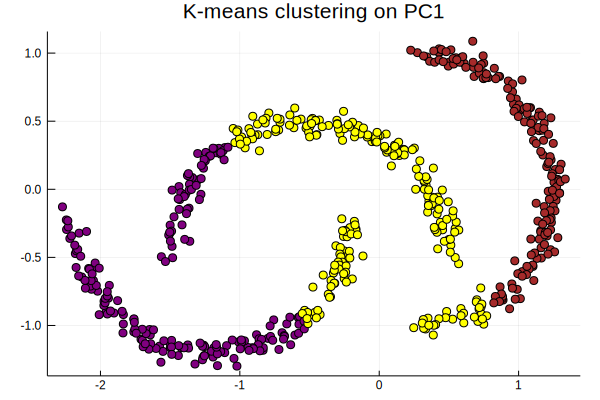

In [5]:
# PCA-based clustering of three moons
X = moons * V
PC1 = X[:,1]
assignments = kmeans(PC1', 3).assignments
inds1, inds2, inds3 = [findall(assignments .== i) for i = 1:3]
scatter( moons[inds1,1], moons[inds1,2], color="purple", label="")
scatter!(moons[inds2,1], moons[inds2,2], color="brown",  label="")
scatter!(moons[inds3,1], moons[inds3,2], color="yellow", label="")
title!("K-means clustering on PC1")

In [6]:
# Isomap on three moons
function isomap(X, Knn::Int64)
    n = size(X, 1)
    D = zeros(n, n)
    # all-pairs distances
    for i = 1:n, j = i:n
        D[i, j] = norm(vec(moons[i,:]) - vec(moons[j,:]), 2)
    end
    # k-nearest neighbors
    DX = zeros(n, n)
    for i = 1:n
        nn = sortperm(D[:, i])[2:(Knn+1)]
        DX[nn, i] = D[nn, i]
        DX[i, nn] = D[i, nn]
    end
    # shortest paths
    DG = Inf * ones(n, n)
    for i = 1:n, j = 1:n
        if DX[i, j] > 0; DG[i, j] = DX[i, j] end
    end
    DG = min.(DG, DG')
    for k = 1:n, j = 1:n, i = 1:n
        #if k == n; @show DG[i, j], DG[i, k] + DG[k, j]; end
        DG[i, j] = min(DG[i, j], DG[i, k] + DG[k, j])
        DG[j, i] = DG[i, j]
        #if k == n; @show DG[i, j]; end
    end
    H = (I - ones(n, n) / n)  # centering matrix
    τG = -H * (DG .^ 2) * H / 2
    Λ, V = eigen(τG)
    return DG, Λ, V
end
DG, Λ, V = isomap(moons, 5);

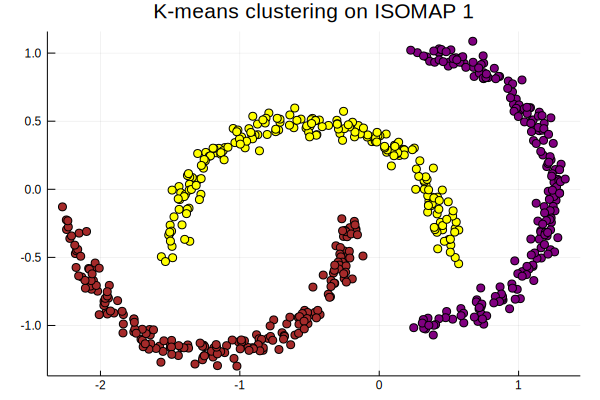

In [7]:
# Isomap-based clustering
X = V[:,1] * sqrt(Λ[1])
assignments = kmeans(X[:,1]', 3).assignments
inds1, inds2, inds3 = [findall(assignments .== i) for i = 1:3]
scatter( moons[inds1,1], moons[inds1,2], color="purple", label="")
scatter!(moons[inds2,1], moons[inds2,2], color="brown",  label="")
scatter!(moons[inds3,1], moons[inds3,2], color="yellow", label="")
title!("K-means clustering on ISOMAP 1")

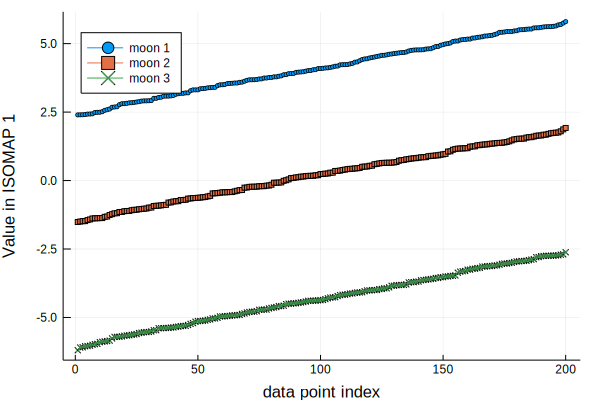

In [8]:
# ISOMAP values
plot( sort(X[1:N,1]),           marker=:circle, markersize=2, label="moon 1", legend=:topleft)
plot!(sort(X[(N+1):(2*N),1]),   marker=:square, markersize=2, label="moon 2")
plot!(sort(X[(2*N+1):(3*N),1]), marker=:X, markersize=2, label="moon 3")
xlabel!("data point index")
ylabel!("Value in ISOMAP 1")

In [9]:
# LLE find weights
function LLE_weights(X, Knn::Int64)
    # all-pairs distances
    n = size(X, 2)
    D = zeros(n, n)
    for i = 1:n, j = i:n; D[i, j] = norm(X[:,i] - X[:,j]); end
    D = D + D'
    neighbors = Vector{Vector{Int64}}()
    weights = Vector{Vector{Float64}}()
    # Solve for weights
    for i = 1:n
        model = Model(with_optimizer(Gurobi.Optimizer))
        Xi = X[:, i]
        Ni = sortperm(D[:, i])[2:(Knn+1)]
        push!(neighbors, Ni)
        @variable(model, Wi[1:Knn])
        @objective(model, Min, sum((X[:, Ni] * Wi - Xi).^2))
        @constraint(model, sum(Wi) == 1)
        @constraint(model, Wi .>= 0.0001) # some regularization
        optimize!(model)
        push!(weights, [value(v) for v in Wi])
    end
    return neighbors, weights
end
neighbors, weights = LLE_weights(moons', 10);

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Optimize a model with 11 rows, 10 columns and 20 nonzeros
Model has 55 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 2e+00]
  QObjective range [2e+00, 5e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-04, 1e+00]
Presolve removed 10 rows and 0 columns
Presolve time: 0.00s
Presolved: 1 rows, 10 columns, 10 nonzeros
Presolved model has 55 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 2
 AA' NZ     : 3.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0  -2.19424816e+04  1.07905237e+00  1.03e+04 2.30e+00  9.96e+05     0s
   1  -2.09750712e+01 -9.94231466e+02  9.83e+00 2.40e-08  1.05e+03     0s
   2   

In [10]:
# LLE reconstruction (one-dimensional)
function LLE_rep(neighbors::Vector{Vector{Int64}},
                 weights::Vector{Vector{Float64}})    
    Is, Js, V = Int64[], Int64[], Float64[]
    for (i, (nbrs, wts)) in enumerate(zip(neighbors, weights))
        for (nbr, wt) in zip(nbrs, wts)
            push!(Is, i); push!(Js, nbr); push!(V, wt)
        end
    end
    n = length(weights)
    W = sparse(Is, Js, V, n, n)
    M = Matrix((I - W)' * (I - W))
    Λ, V = eigen(Matrix(M))
    return Λ, V
end

Λ, V = LLE_rep(neighbors, weights)

([-2.90893e-16, 1.13798e-17, 1.64561e-8, 5.96186e-7, 2.51711e-6, 3.21335e-6, 7.15769e-6, 2.00579e-5, 2.69357e-5, 8.33128e-5  …  3.80347, 3.85167, 3.85528, 3.87855, 3.88841, 3.91615, 3.92049, 3.92227, 3.95607, 3.96085], [-0.05 0.0 … -0.00392177 -1.65733e-12; -0.05 0.0 … 0.00311626 1.31873e-12; … ; 0.0 -0.0707107 … 0.0 0.0; 0.0 -0.0707107 … 0.0 0.0])

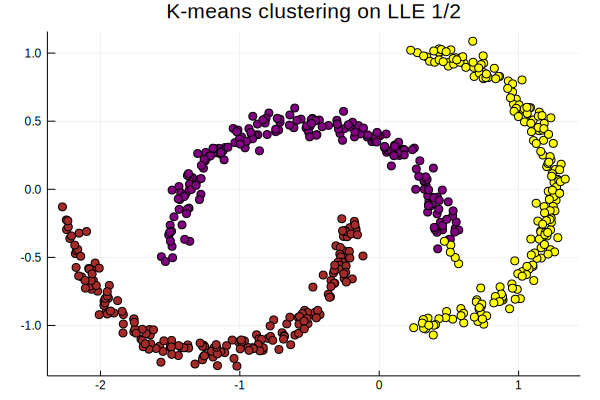

In [11]:
# LLE-based clustering
assignments = kmeans(V[:,1:2]', 3).assignments
inds1, inds2, inds3 = [findall(assignments .== i) for i = 1:3]
scatter( moons[inds1,1], moons[inds1,2], color="purple", label="")
scatter!(moons[inds2,1], moons[inds2,2], color="brown",  label="")
scatter!(moons[inds3,1], moons[inds3,2], color="yellow", label="")
title!("K-means clustering on LLE 1/2")